In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import os
import cv2
import sys
import pywt
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from resnet import resnet
from skimage.measure import compare_psnr, compare_ssim, compare_mse, compare_nrmse, shannon_entropy

# Solve lib error
os.environ['KMP_DUPLICATE_LIB_OK']='True'
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [3]:
import rec_utils

# Load data

In [4]:
import keras
from keras.datasets import cifar10

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Reconstruction

In [7]:
def random_drop(img, ws, ratio):
    h, w = img.shape[:2]
    drop_map = np.zeros((h, w))
    img_drop = img.copy()
    for i, j in itertools.product(range(h // ws), range(w // ws)):
        drop_index = random.sample(range(ws ** 2), np.int(np.round(ws ** 2 * ratio)))
        for d in drop_index:
            x, y = i * ws + d % ws, j * ws + d // ws
            img_drop[x, y], drop_map[x, y] = 0, 1

    return img_drop, drop_map

In [24]:
def image_recovery(img_drop, drop_map, ws, delta, mu):
    h, w = img_drop.shape[:2]
    img_rec = img_drop.copy()
    for i, j in itertools.product(range(h // ws), range(w // ws)):
        img1 = img_drop[i * ws:(i + 1) * ws, j * ws:(j + 1) * ws].copy()
        img2 = img_drop[i * ws:(i + 1) * ws, j * ws:(j + 1) * ws].copy()
        for k, l in itertools.product(range(ws), range(ws)):
            if drop_map[i * ws + k, j * ws + l] == 1:
                img1[k, l] = np.min((1.0, img1[k, l] + delta))
                img2[k, l] = np.max((0.0, img1[k, l] - delta))
                dct1 = cv2.dct(img1)
                dct2 = cv2.dct(img2)
                Y1 = np.sum(np.abs(dct1))
                Y2 = np.sum(np.abs(dct2))
                grad = (Y1 - Y2) / (2 * delta)
                img_rec[i * ws + k, j * ws + l] -= mu * grad

    return img_rec

In [9]:
def recovery_iter(img_drop, drop_map, ws, delta, mu, eps=1e-05, max_iters=100):
    max_mse = 0
    gamma = 0.01
    img_rec_0 = img_drop.copy()
    img_rec = np.zeros(img_drop.shape)
    for i in range(max_iters):
        for c in range(3):
            img_rec[:, :, c] = image_recovery(img_rec_0[:, :, c], drop_map, ws, delta, mu)
        img_rec = np.clip(img_rec, 0, 1)
        mse = compare_mse(img_rec_0, img_rec)
        if mse > max_mse:
            max_mse = mse
        elif mse < gamma * max_mse:
            delta /= 10
            mu /= 10
            if mse < eps:
                break
            max_mse = mse

        img_rec_0 = img_rec.copy()

    return img_rec

# Load model

In [10]:
def accuracy(pred, real):
    return np.sum(np.argmax(pred, 1) == np.argmax(real, 1)) / pred.shape[0]

In [11]:
model_path = "../models/resnet29_cifar10.h5"
n = 3
depth = n * 9 + 2
input_shape = x_train.shape[1:]
model = resnet(input_shape=input_shape, depth=depth, num_classes=10).build()
model.load_weights(model_path)

# Cifar10 test

In [50]:
ratio = 0.1
window_size = 4
delta = 0.03 # 10 / 255
mu = 0.02 # 5 / 255

In [51]:
test_id = 2
test_img = x_test[test_id].astype('float32') / 255

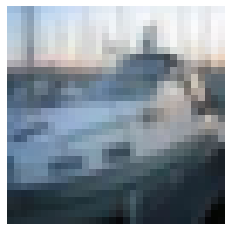

In [52]:
plt.imshow(test_img)
plt.axis('off')
plt.show()

In [53]:
test_img_drop, test_drop_map = rec_utils.random_drop(test_img, window_size, ratio)

In [54]:
test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, window_size, delta, mu, max_iters=100)

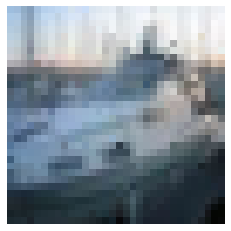

In [55]:
plt.imshow(test_img_rec)
plt.axis('off')
plt.show()

In [56]:
compare_psnr(test_img, test_img_rec)

31.89631234937734

In [57]:
test_img_rec = recovery_iter(test_img_drop, test_drop_map, window_size, delta, mu, max_iters=100)

In [58]:
compare_psnr(test_img, test_img_rec)

31.316414455158117

# Time comparison

In [419]:
%timeit test_img_rec = rec_utils.recovery_iter(test_img_drop, test_drop_map, window_size, delta, mu, max_iters=100)

147 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [420]:
%timeit pred = model.predict(np.expand_dims(test_img_rec, axis=0))

8.39 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
